In [1]:
from microstruktur.signal_models import cylinder_models, gaussian_models
from microstruktur.core import modeling_framework, acquisition_scheme
from microstruktur.utils import utils
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

# Synthetic Experiment

In [2]:
from microstruktur.data import saved_acquisition_schemes, saved_data
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

## Get an intial guess for orientation using Dipy's DTI

In [3]:
from dipy.reconst import dti

gtab = acquisition_scheme.gtab_mipy2dipy(scheme)
tenmod = dti.TensorModel(gtab)
tenfit_parallel = tenmod.fit(synthetic_data_parallel.signal_attenuation)
tenfit_dispersed = tenmod.fit(synthetic_data_dispersed.signal_attenuation)

In [4]:
mu_parallel_cart = tenfit_parallel.directions.squeeze()
mu_dispersed_cart = tenfit_dispersed.directions.squeeze()

In [5]:
from microstruktur.utils.utils import cart2sphere
mu_parallel = utils.cart2mu(mu_parallel_cart)
mu_dispersed = utils.cart2mu(mu_dispersed_cart)

## Generate Ball and Stick model

In [6]:
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()

ball_and_stick = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme,
    models=[stick, ball]
)

## Fit Ball and Stick to data

In [7]:
param_parallel_x0 = ball_and_stick.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu_parallel  # initialization stick parameters
)
param_dispersed_x0 = ball_and_stick.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu_dispersed  # initialization stick parameters
)

C1Stick_1_mu successfully set.
C1Stick_1_mu successfully set.


In [8]:
# fitting to parallel (undispersed) data varying diffusivity D=[1.7, 2.0, 2.3]
results_ball_and_stick_multidif = ball_and_stick.fit(
    synthetic_data_parallel.signal_attenuation,
    parameter_initial_guess=param_parallel_x0,
    Ns=5, use_parallel_processing=True)

# fitting to dispersed data varying diffusivity D=[1.7, 2.0, 2.3]
results_ball_and_stick_multidif_dispersed = ball_and_stick.fit(
    synthetic_data_dispersed.signal_attenuation,
    parameter_initial_guess=param_dispersed_x0,
    Ns=5, use_parallel_processing=True)

# we separate the first one-third of the results that come from only D=1.7x10^-9 m/s^2 data
ind_1_7_parallel = synthetic_data_parallel.diffusivities == 1.7e-9
ind_1_7_dispersed = synthetic_data_dispersed.diffusivities == 1.7e-9

fractions_1_7 = synthetic_data_parallel.fractions[ind_1_7_parallel]
fractions_1_7_dispersed = synthetic_data_dispersed.fractions[ind_1_7_dispersed]
results_ball_and_stick_1_7 = results_ball_and_stick_multidif[ind_1_7_parallel]
results_ball_and_stick_dispersed_1_7 = results_ball_and_stick_multidif_dispersed[
    ind_1_7_dispersed]

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 3.56299901009 seconds.
Average of 0.0107969666972 seconds per voxel.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 28.8760979176 seconds.
Average of 0.00972259189143 seconds per voxel.


In [9]:
pr = pearsonr(
    results_ball_and_stick_1_7[:, -1], fractions_1_7)
pr_dispersed = pearsonr(
    results_ball_and_stick_dispersed_1_7[:, -1], fractions_1_7_dispersed)
pr_multidif = pearsonr(
    results_ball_and_stick_multidif[:, -1], synthetic_data_parallel.fractions)
pr_multidif_dispersed = pearsonr(
    results_ball_and_stick_multidif_dispersed[:, -1], synthetic_data_dispersed.fractions)

(0.2, 0.8)

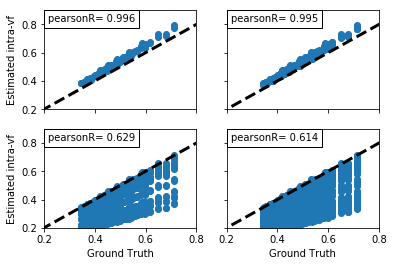

In [10]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.scatter(fractions_1_7, results_ball_and_stick_1_7[:, -1])
ax2.scatter(synthetic_data_parallel.fractions, results_ball_and_stick_multidif[:, -1])
ax3.scatter(fractions_1_7_dispersed, results_ball_and_stick_dispersed_1_7[:, -1])
ax4.scatter(synthetic_data_dispersed.fractions, results_ball_and_stick_multidif_dispersed[:, -1])

ax1.text(.216, .817, 'pearsonR= ' + str(np.round(pr[0], 3)),
         fontsize=10, bbox=dict(facecolor='white', alpha=1))
ax2.text(.216, .817, 'pearsonR= ' + str(np.round(pr_multidif[0], 3)),
         fontsize=10, bbox=dict(facecolor='white', alpha=1))
ax3.text(.216, .817, 'pearsonR= ' + str(np.round(pr_dispersed[0], 3)),
         fontsize=10, bbox=dict(facecolor='white', alpha=1))
ax4.text(.216, .817, 'pearsonR= ' + str(np.round(pr_multidif_dispersed[0], 3)),
         fontsize=10, bbox=dict(facecolor='white', alpha=1))

# ax1.set_title('Static Diffusivity')
ax3.set_xlabel('Ground Truth')
# ax2.set_title('Varying Diffusivity')
ax1.set_ylabel('Estimated intra-vf')
ax4.set_xlabel('Ground Truth')
ax3.set_ylabel('Estimated intra-vf')

ax1.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax2.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax3.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax4.plot([0, 1], [0, 1], ls='--', c='k', lw=3)
ax1.set_ylim(0.2, .9)
ax1.set_xlim(0.2, .8)
ax4.set_ylim(0.2, .9)
ax4.set_xlim(0.2, .8)

# Human Connectome Project Example

In [11]:
from microstruktur.data import saved_data
data = saved_data.wu_minn_hcp_coronal_slice()

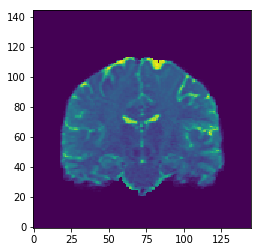

In [12]:
plt.imshow(data[:,0,:,0].T, origin=True)

## Get an intial guess for orientation using Dipy's DTI

In [13]:
tenmod = dti.TensorModel(gtab)
tenfit = tenmod.fit(data, mask=data[..., 0]>0)

In [14]:
mu_cart = tenfit.directions[..., 0, :]
mu = utils.cart2mu(mu_cart)

param_x0 = ball_and_stick.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu,
)

C1Stick_1_mu successfully set.


/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/utils/utils.py:331: RuntimeWarning: invalid value encountered in divide
  mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta


## Fit Ball and Stick model to HCP data

In [15]:
fitted_parameter_vector_hcp = ball_and_stick.fit(
    data=data, mask=data[..., 0]>0,
    parameter_initial_guess=param_x0,
    Ns=5, use_parallel_processing=True)

fitted_parameters = ball_and_stick.parameter_vector_to_parameters(fitted_parameter_vector_hcp)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 99.3670189381 seconds.
Average of 0.0121460724775 seconds per voxel.


## Visualize results

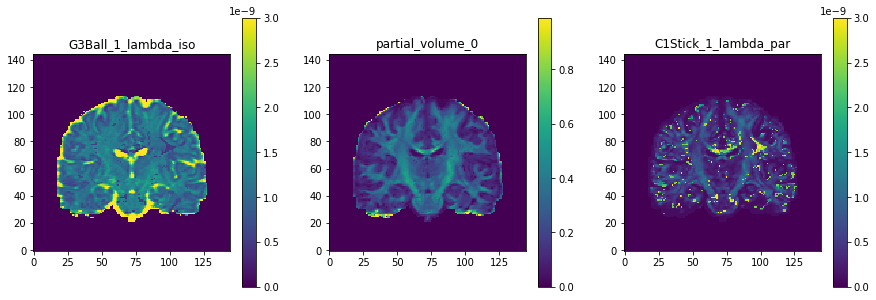

In [16]:
fig, axs = plt.subplots(1, len(fitted_parameters) - 1, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if np.squeeze(values).ndim != 2:
        continue
    cf = axs[counter].imshow(np.squeeze(values).T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.33)
    counter += 1

Notice that using this very simple model we get some familiar maps, where the Ball model takes the role of extra-axonal and CSF compartments, and the stick takes the intra-axonal compartment. 

Also notice that the maps are not completely smooth (especially lambda_par) as optimization can still fall in a local minima despite the brute force optimization. 

## Fixing Parameters during optimization

Model parameters are often fixed to a static value to force certain model behaviour. For instance, often parallel diffusivity is fixed to $\lambda_\parallel=1.7e-9m^2/s$. In Mipy, fixing parameters can be easily done by setting the optimization flag for that parameter to False:

In [17]:
param_x0 = ball_and_stick.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu,
    C1Stick_1_lambda_par=1.7e-9  # now also set initial guess to the fixed value
)

# then set the optimization flag for that parameter to False
ball_and_stick.optimized_parameters['C1Stick_1_lambda_par'] = False

# then just proceed as before
fitted_parameter_vector_hcp_fixed = ball_and_stick.fit(
    data=data, mask=data[..., 0]>0,
    parameter_initial_guess=param_x0,
    Ns=5, use_parallel_processing=True)

fitted_parameters_fixed = ball_and_stick.parameter_vector_to_parameters(fitted_parameter_vector_hcp_fixed)

C1Stick_1_mu successfully set.
C1Stick_1_lambda_par successfully set.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 55.9885210991 seconds.
Average of 0.00684372584025 seconds per voxel.


Notice that fitting was now also twice as fast since lambda_par is now not optimized.

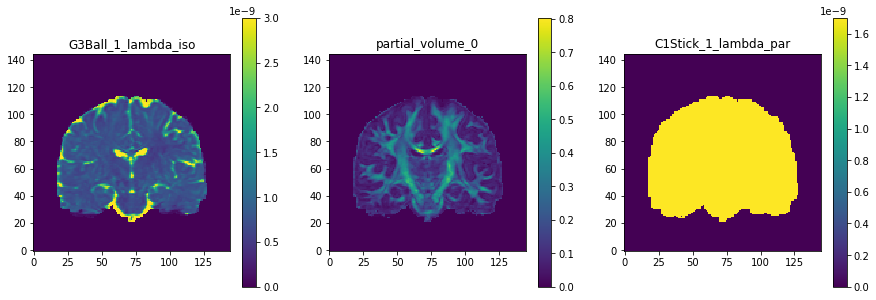

In [18]:
fig, axs = plt.subplots(1, len(fitted_parameters_fixed) - 1, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters_fixed.items():
    if np.squeeze(values).ndim != 2:
        continue
    cf = axs[counter].imshow(np.squeeze(values).T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.33)
    counter += 1

Notice that nose lambda_par is always set to 1.7e-9, and the other parameters are now optimized while using that constraint. See that lambda_iso and partial_volume are now completely smooth, but will be biased if the parallel diffusivity is not 1.7e-9 in reality.